### References:
- [Kaggle dataset](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?datasetId=576013&sortBy=voteCount)
- Some code is borrowed from this [notebook](https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial)

In [1]:
import os
import time
import copy
from random import shuffle

import cv2
from PIL import Image
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import tqdm.notebook as tqdm

import matplotlib.pyplot as plt

In [4]:
from pathlib import Path


DATA_PATH = Path('/gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3//')
print('Num images', len(list(DATA_PATH.glob('**/images/*.png'))))
classes_path = list(f for f in DATA_PATH.glob('*') if f.is_dir())
#classes_path = classes_path[2:] # for Covid and Normal
classes_path

Num images 7578


[PosixPath('/gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3/COVID'),
 PosixPath('/gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3/Normal')]

In [3]:
DATA_PATH

PosixPath('/gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset')

In [16]:
#classes_path[2:]

/gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3/explanator_val.csv
/gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3/README.md.txt
/gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3/Normal.metadata.xlsx
/gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3/COVID
/gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3/COVID.metadata.xlsx
/gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3/classifier_train.csv
/gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3/.DS_Store
/gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3/classifier_validation.csv
/gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3/Normal
/gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3/sampler_labels.n

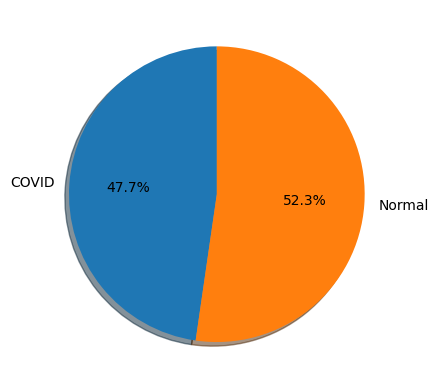

In [5]:
image_count = {}
for c in DATA_PATH.glob('*'):
    print(c)
    # if "Lung_Opacity" or 'Viral Pneumonia' in c:
    #     continue
    if c.is_file():
        continue
    image_count[c.name] = sum(1 for _ in (c / 'images').glob('*'))


print(image_count)
# Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(), labels=image_count.keys(), shadow=True, autopct='%1.1f%%', startangle=90)
plt.show()

I have taken correct propositions of data from each classes while staging my data to avoid overfitted results. Medical Image Datasets will always be like this, we don't have enough data on victim rather we have so many healthy ones. That is what we called is a "Skewed Dataset", obviously we developed methods to approach those problems (like K-Fold Cross Validation) that will explain that in my next notebook.

Lets view some images to know what we are dealing with here. Feel free the run the cell to view images at random from the repository.

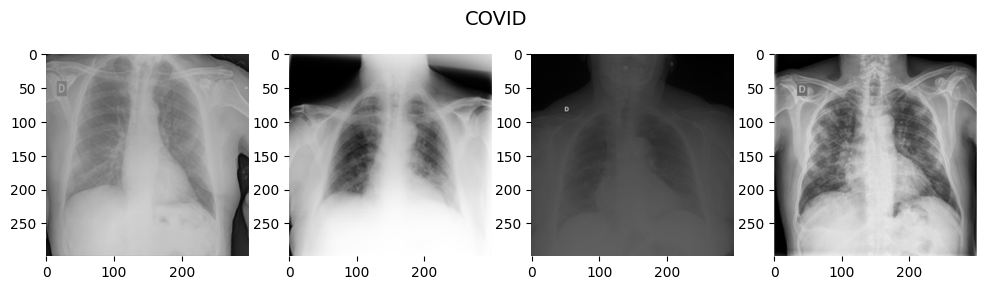

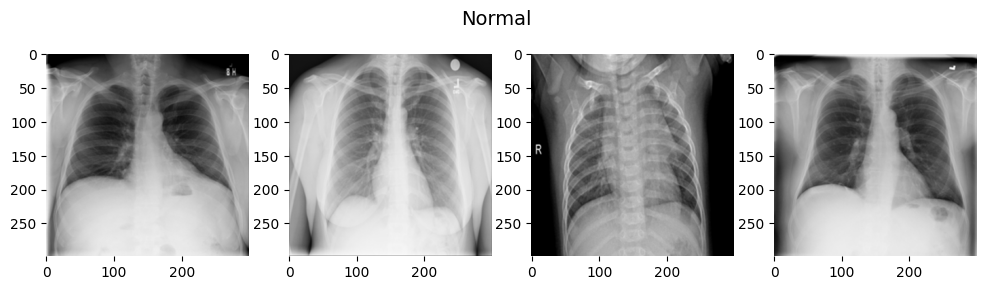

In [6]:
for cp in classes_path:
    fig = plt.figure(figsize=(12, 3))
    fig.suptitle(cp.name, size=14)

    for i, image in enumerate((cp / 'images').glob('*')):
        img = cv2.imread(str(image))
        plt.subplot(1, 4, i + 1, frameon=False)
        plt.imshow(img)
        if i == 3:
            break

In [7]:
import random

def counterfactual_split(train_clf_pct=0.05, train_explanator_pct=0.8, max_samples_per_class=50):
    clf_train, expl_train, expl_val = DATA_PATH / 'classifier_train.csv', DATA_PATH / 'classifier_validation.csv', DATA_PATH / 'explanator_val.csv'
    with open(clf_train, 'w') as ctr, open(expl_train, 'w') as etr, open(expl_val, 'w') as evl:
        for cp in classes_path:
            #paths = list(cp.glob('images/*.png'))
            
            paths = list(cp.glob('images/*.png'))
            random.shuffle(paths)  # Shuffle to ensure randomness
            paths = paths[:max_samples_per_class]  # Limit the number of samples for development


            clf_num_train = int(len(paths) * train_clf_pct)
            ctr.write(
                '\n'.join(cp.name + ',' + str(p.as_posix()) + ',' + (p.parent.parent / 'masks' / p.name).as_posix() for p in paths[:clf_num_train]) + '\n'
            )

            expl_num_train = int(len(paths) * train_explanator_pct)
            etr.write(
                '\n'.join(
                    cp.name + ',' + str(p.as_posix()) + ',' + (p.parent.parent / 'masks' / p.name).as_posix() for p in paths[clf_num_train:expl_num_train]
                )
                + '\n'
            )

            expl_num_val = len(paths) - clf_num_train - expl_num_train
            evl.write(
                '\n'.join(cp.name + ',' + str(p.as_posix()) + ',' + (p.parent.parent / 'masks' / p.name).as_posix() for p in paths[-expl_num_val:]) + '\n'
            )
            print('num', cp.name, f'total={len(paths)};', 'split={}/{}/{}'.format(clf_num_train, expl_num_train, expl_num_val))
    return clf_train, expl_train, expl_val


# set max samples per class as max value for each class

classifier_train_csv, classifier_val_csv, exlp_val_csv = counterfactual_split(train_clf_pct=0.05, 
                                                                              train_explanator_pct=0.8,
                                                                              max_samples_per_class=-1)
print('Classifier training annots:', classifier_train_csv)
print('Classifier validation annots:', classifier_val_csv)
print('Explanator validation annots:', exlp_val_csv)

num COVID total=3615; split=180/2892/543
num Normal total=3961; split=198/3168/595
Classifier training annots: /gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3/classifier_train.csv
Classifier validation annots: /gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3/classifier_validation.csv
Explanator validation annots: /gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset_v3/explanator_val.csv


In [8]:
imagenet_mean = 0.485, 0.456, 0.406
imagenet_std = 0.229, 0.224, 0.225
grayscale_coefs = 0.2989, 0.587, 0.114

grayscale_mean = sum(m * c for m, c in zip(imagenet_mean, grayscale_coefs))
grayscale_std = sum(m * c for m, c in zip(imagenet_std, grayscale_coefs))
# grayscale, mean_nums, std_nums
grayscale_mean, grayscale_std

(0.4589225, 0.2255861)

In [9]:
import albumentations as albu


# imagenet norm stats converted to grayscale
# mean = [grayscale_mean]
# std = [grayscale_std]
mean = [0.5]
std = [0.5]

data_transforms = {
    "train": albu.Compose(
        [
            albu.HorizontalFlip(p=0.5),
            albu.VerticalFlip(p=0.1),
            albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.07, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
            albu.Resize(256, 256, cv2.INTER_CUBIC),
            albu.Normalize(mean, std),
        ]
    ),
    "val": albu.Compose(
        [
            albu.Resize(256, 256, cv2.INTER_CUBIC),
            albu.Normalize(mean, std),
        ]
    ),
}

In [9]:
classifier_train_csv

PosixPath('/gpfs/space/home/shoush/nn_project/project/datasets/COVID-19_Radiography_Dataset/classifier_train.csv')

Text(0.5, 1.0, 'COVID')

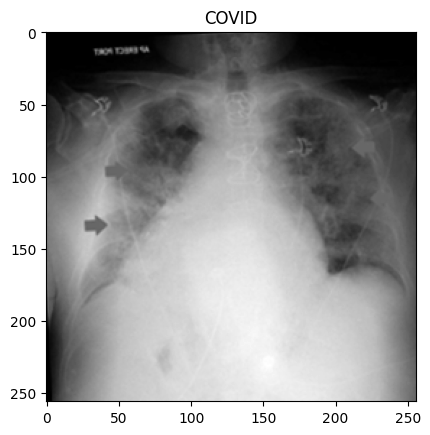

In [10]:
class LungsDataset(torch.utils.data.Dataset):
    CLASSES = 'Normal', 'COVID' # 'Lung_Opacity', 'Viral Pneumonia', 'Normal', 'COVID'
    #'normal', 'lung_opacity', 'viral_pneumonia', 'covid'

    def __init__(self, ann_path, transforms=None):
        self.labels, self.image_paths, self.mask_paths = self._load_anns(ann_path)
        self.labels = [self.CLASSES.index(lb) for lb in self.labels]
        self.transforms = transforms

    def _load_anns(self, ann_path):
        with open(ann_path) as fid:
            return zip(*(line.rstrip().split(',') for line in fid))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        label, img_path, mask_path = self.labels[index], self.image_paths[index], self.mask_paths[index]
        img = np.array(Image.open(img_path))
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = np.array(Image.open(mask_path))

        sample = {
            'image': img,
            'mask': mask,
        }
        if self.transforms:
            sample = self.transforms(**sample)
        sample['label'] = label
        sample['image'] = sample['image'][np.newaxis]
        sample['mask'] = (sample['mask'] / 255)[np.newaxis]
        return sample

    def get_labels(self):
        # required by https://github.com/ufoym/imbalanced-dataset-sampler/blob/master/torchsampler/imbalanced.py
        return self.labels


train_dst = LungsDataset(classifier_train_csv, data_transforms['train'])
sample = train_dst[0]
plt.imshow(sample['image'][0], cmap='gray')
plt.title(train_dst.CLASSES[sample['label']])
# val_dst = LungsDataset(DATA_PATH / 'val.csv', data_transforms['val'])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 1.0, 'Lung_Opacity')

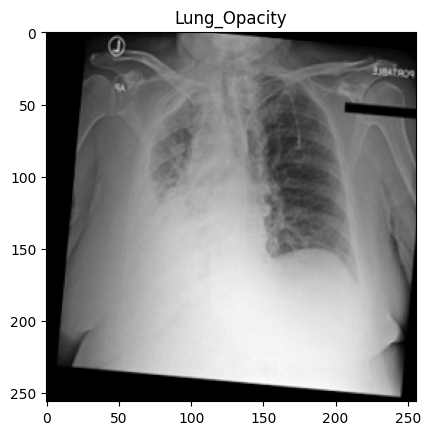

In [85]:
# import torch
# import cv2
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

# class LungsDataset(torch.utils.data.Dataset):
#     CLASSES = 'Lung_Opacity', 'Viral Pneumonia', 'Normal', 'COVID'

#     def __init__(self, ann_path, transforms=None):
#         self.labels, self.image_paths, self.mask_paths = self._load_anns(ann_path)
#         self.labels = [self.CLASSES.index(lb) for lb in self.labels]
#         #print(self.labels)
#         self.transforms = transforms
        
#         # self.label_mapping = {
#         #     0: 1,  # 'Lung_Opacity' -> 'abnormal'
#         #     1: 1,  # 'Viral Pneumonia' -> 'abnormal'
#         #     2: 0,  # 'Normal' -> 'Normal'
#         #     3: 1   # 'COVID' -> 'abnormal'
#         # }

#     def _load_anns(self, ann_path):
#         with open(ann_path) as fid:
#             labels, image_paths, mask_paths = zip(*(line.rstrip().split(',') for line in fid))
#         return list(labels), list(image_paths), list(mask_paths)

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, index):
#         original_label, img_path, mask_path = self.labels[index], self.image_paths[index], self.mask_paths[index]
#         #binary_label = self.label_mapping[original_label]

#         img = np.array(Image.open(img_path))
#         if len(img.shape) == 3:
#             img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         mask = np.array(Image.open(mask_path))

#         sample = {
#             'image': img,
#             'mask': mask,
#         }
#         if self.transforms:
#             sample = self.transforms(**sample)
#         sample['label'] = original_label
#         sample['image'] = sample['image'][np.newaxis]
#         sample['mask'] = (sample['mask'] / 255)[np.newaxis]
#         return sample

#     def get_labels(self):
#         # required by https://github.com/ufoym/imbalanced-dataset-sampler/blob/master/torchsampler/imbalanced.py
#         #return [self.label_mapping[label] for label in self.labels]
        
#         self.labels
    
    


# train_dst = LungsDataset(classifier_train_csv, data_transforms['train'])
# sample = train_dst[0]
# plt.imshow(sample['image'][0], cmap='gray')
# plt.title(train_dst.CLASSES[sample['label']])

# # val_dst = LungsDataset(DATA_PATH / 'val.csv', data_transforms['val'])



# # Example usage
# # classifier_train_csv = 'path/to/train_annotations.csv'
# # data_transforms = {'train': None, 'val': None}  # Replace with actual transformations if any

# # train_dst = LungsDataset(classifier_train_csv, data_transforms['train'])
# # sample = train_dst[0]
# # plt.imshow(sample['image'][0], cmap='gray')
# # plt.title('Normal' if sample['label'] == 0 else 'Abnormal')
# # plt.show()

# # val_dst = LungsDataset(DATA_PATH / 'val.csv', data_transforms['val'])


In [11]:
 train_dst.CLASSES

('Normal', 'COVID')

In [12]:
# #sample = train_dst[-100]
# count=0
# for s in train_dst:
#     count+=1
#     #print(count)
#     if train_dst.CLASSES[s['label']]=="Normal":
        
#         plt.imshow(s['image'][0], cmap='gray')
#         plt.title(train_dst.CLASSES[s['label']])
#         break

In [10]:
# label_mapping = {
#     0: 1,  # 'Lung_Opacity' -> 'abnormal'
#     1: 1,  # 'Viral Pneumonia' -> 'abnormal'
#     2: 0,  # 'Normal' -> 'Normal'
#     3: 1   # 'COVID' -> 'abnormal'
# }


# class LungsDataset(torch.utils.data.Dataset):
#     #CLASSES = 'normal', 'lung_opacity', 'viral_pneumonia', 'covid'
#     CLASSES = 'Lung_Opacity', 'Viral Pneumonia', 'Normal', 'COVID'

#     def __init__(self, ann_path, transforms=None):
#         self.labels, self.image_paths, self.mask_paths = self._load_anns(ann_path)
#         print(self.labels)
#         self.labels = [self.CLASSES.index(lb) for lb in self.labels]
#         self.transforms = transforms
        
#         self.label_mapping = {
#             0: 1,  # 'Lung_Opacity' -> 'abnormal'
#             1: 1,  # 'Viral Pneumonia' -> 'abnormal'
#             2: 0,  # 'Normal' -> 'Normal'
#             3: 1   # 'COVID' -> 'abnormal'
#         }

#     def _load_anns(self, ann_path):
#         with open(ann_path) as fid:
#             return zip(*(line.rstrip().split(',') for line in fid))

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, index):
#         label, img_path, mask_path = self.labels[index], self.image_paths[index], self.mask_paths[index]
#         img = np.array(Image.open(img_path))
#         if len(img.shape) == 3:
#             img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         mask = np.array(Image.open(mask_path))

#         sample = {
#             'image': img,
#             'mask': mask,
#         }
#         if self.transforms:
#             sample = self.transforms(**sample)
#         sample['label'] = label
#         sample['image'] = sample['image'][np.newaxis]
#         sample['mask'] = (sample['mask'] / 255)[np.newaxis]
#         return sample

#     def get_labels(self):
#         # required by https://github.com/ufoym/imbalanced-dataset-sampler/blob/master/torchsampler/imbalanced.py
#         return self.labels


# train_dst = LungsDataset(classifier_train_csv, data_transforms['train'])
# sample = train_dst[0]
# plt.imshow(sample['image'][0], cmap='gray')
# plt.title(train_dst.CLASSES[sample['label']])
# # val_dst = LungsDataset(DATA_PATH / 'val.csv', data_transforms['val'])

In [12]:
from torchsampler import ImbalancedDatasetSampler

def get_dataloaders(batch_size=16, use_sampler=True, shuffle_test=True):
    train_data = LungsDataset(classifier_train_csv, data_transforms['train'])
    train_sampler = ImbalancedDatasetSampler(train_data) if use_sampler else None

    test_data = LungsDataset(classifier_val_csv, data_transforms['val'])

    train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, shuffle=train_sampler is None, batch_size=batch_size, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=shuffle_test, pin_memory=True)
    return train_loader, test_loader

train_loader, test_loader = get_dataloaders()
batch = next(iter(train_loader))

# Check the labels in the batch to ensure they are binary
images, labels = batch['image'], batch['label']
print(labels)


tensor([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1])


In [12]:
# from torchsampler import ImbalancedDatasetSampler


# def get_dataloaders(batch_size=16, use_sampler=True, shuffle_test=True):
#     train_data = LungsDataset(classifier_train_csv, data_transforms['train'])
#     train_sampler = ImbalancedDatasetSampler(train_data) if use_sampler else None

#     test_data = LungsDataset(classifier_val_csv, data_transforms['val'])

#     train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, shuffle=train_sampler is None, batch_size=batch_size, pin_memory=True)
#     test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=shuffle_test, pin_memory=True)
#     return train_loader, test_loader


# train_loader, test_loader = get_dataloaders()
# batch = next(iter(train_loader))

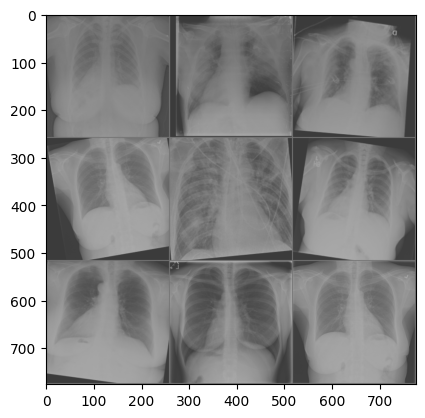

In [13]:
def imshow(inp, size=(30, 30), title=None, ax=None):
    inp = inp * grayscale_std + grayscale_mean
    inp = inp.numpy().transpose((1, 2, 0))
    if ax is None:
        plt.figure(figsize=size)
        plt.imshow(inp, ax=ax)
    ax.imshow(inp)
    if title is not None:
        plt.title(title, size=30)


batch = next(iter(train_loader))
out = torchvision.utils.make_grid(batch['image'][:9], nrow=3)
imshow(out, ax=plt.gca())

In [14]:
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda', index=0)

In [15]:
torch.cuda.empty_cache()

In [16]:
# import torchvision.models as models

# def get_model(pretrained=True):
#     model = models.resnet18(pretrained=pretrained)
#     num_features = model.fc.in_features
#     model.fc = nn.Linear(num_features, 2)  # Adjust output layer to 2 classes
#     return model

# model = get_model(pretrained=True)
# model = model.to(device)


In [15]:
def get_model(pretrained=True):
    model = models.resnet18(pretrained=pretrained)  # Returns Defined Densenet model with weights trained on ImageNet
    #     in_conv = model.features.conv0
    in_conv = model.conv1
    # reset input layer to accept grayscale images
    model.conv1 = torch.nn.Conv2d(
        1, in_conv.out_channels, in_conv.kernel_size, in_conv.stride, in_conv.padding, in_conv.dilation, in_conv.groups, in_conv.bias, in_conv.padding_mode
    )
    model.conv1.weight.data.copy_(in_conv.weight.mean(dim=1, keepdims=True))
    if in_conv.bias is not None:
        model.conv1.bias.data.copy_(in_conv.bias)

    # reset the classification layer
    num_ftrs = model.fc.in_features
    #model.fc = nn.Linear(num_ftrs, len(LungsDataset.CLASSES))
    # model.fc = nn.Linear(num_ftrs, 4)  # Adjust output layer to 2 classes
    model.fc = nn.Linear(num_ftrs, 2)  # Adjust output layer to 2 classes
    model = model.to(device)
    return model

In [16]:
from sklearn.metrics import classification_report


def train_epoch(loader, model, criterion, optimizer, report=False):
    model.train()
    current_loss = 0.0
    pred_list, true_list = [], []
    for batch in tqdm.tqdm(loader, desc='train', leave=False):
        inputs, labels = batch['image'].to(device), batch['label'].to(device)
        #print(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        #         preds = (outputs > 0).byte()
        #         loss = criterion(outputs, labels.float().unsqueeze(1))
        preds = outputs.argmax(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
        #         pred_list.extend(preds.squeeze(1).cpu().numpy())
        pred_list.extend(preds.cpu().numpy())
        true_list.extend(labels.cpu().numpy())
    if report:
        report = classification_report(true_list, pred_list, target_names=loader.dataset.CLASSES)
        #report = classification_report(true_list, pred_list,target_names=['Normal', 'Abnormal'])
        print(report)
    return current_loss / len(loader)


@torch.no_grad()
def validation_epoch(loader, model, criterion):
    model.eval()

    current_loss = 0.0
    pred_list, true_list = [], []
    for batch in tqdm.tqdm(loader, desc='val', leave=False):
        inputs, labels = batch['image'].to(device), batch['label'].to(device)
        outputs = model(inputs)
        #         preds = (outputs > 0).byte()
        #         loss = criterion(outputs, labels.float().unsqueeze(1))
        preds = outputs.argmax(1)
        loss = criterion(outputs, labels)
        # We want variables to hold the loss statistics
        current_loss += loss.item()
        #         pred_list.extend(preds.squeeze(1).cpu().numpy())
        pred_list.extend(preds.cpu().numpy())
        true_list.extend(labels.cpu().numpy())

    # report = classification_report(true_list, pred_list, target_names=loader.dataset.CLASSES)
    # report = classification_report(true_list, pred_list, target_names=['Lung_Opacity', 'Viral Pneumonia', 'Normal', 'COVID'])
    report = classification_report(true_list, pred_list, target_names=[ 'Normal', 'COVID'])
    print('Validation report:')
    print(report)
    return current_loss / len(loader)


def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        train_epoch_loss = train_epoch(dataloaders['train'], model, criterion, optimizer)
        print('Epoch {}. Train Loss: {:.4f}'.format(epoch + 1, train_epoch_loss))

        val_epoch_loss = validation_epoch(dataloaders['val'], model, criterion)
        print('Epoch {}. Validation Loss: {:.4f}'.format(epoch + 1, val_epoch_loss))

        scheduler.step()
        print('LR:', optimizer.param_groups[0]['lr'])

        if val_epoch_loss < best_loss:
            print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, val_epoch_loss))
            best_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)
    return model

In [17]:
from collections import Counter
import numpy as np
import torch

# Assuming train_loader and device are already defined
train_labels = np.array(train_loader.dataset.get_labels())
print(set(train_labels))

counts = Counter(train_labels)
print(counts)

# Create class weights
class_weights = torch.zeros(len(counts)).to(device)
for c, v in counts.items():
    class_weights[c] = 1.0 - v / len(train_labels)

# Print class weights
print(class_weights)


{0, 1}
Counter({0: 198, 1: 180})
tensor([0.4762, 0.5238], device='cuda:0')


In [20]:
# from collections import Counter

# train_labels = np.array(train_loader.dataset.labels)

# counts = Counter(train_labels)
# print(counts)
# class_weights = torch.zeros(len(counts)).to(device)
# for c, v in counts.items():
#     class_weights[c] = 1.0 - v / len(train_labels)
# class_weights
# # num_covid = sum(train_labels)
# # num_normal = len(train_labels) - num_covid
# # class_weights = torch.tensor((1 - num_normal / len(train_labels), 1 - num_covid / len(train_labels))).to(device)
# # class_weights

In [21]:
device

device(type='cuda', index=0)

In [18]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from collections import Counter

# Assuming necessary imports and definitions for get_model and train_model are already in place

# Set random seeds for reproducibility
np.random.seed(777)
torch.manual_seed(777)

# Get data loaders
dataloaders = {'train': train_loader, 'val': test_loader}

# Initialize the model (assuming get_model is defined elsewhere)
model = get_model(pretrained=True)
model = model.to(device)

# Calculate class weights
train_labels = np.array(train_loader.dataset.get_labels())
counts = Counter(train_labels)
print(counts)

class_weights = torch.zeros(len(counts)).to(device)
for c, v in counts.items():
    class_weights[c] = 1.0 - v / len(train_labels)

print(class_weights)

# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 5], gamma=0.5)

# Print the number of trainable parameters
print('Number of trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

# Train the model (assuming train_model is defined elsewhere)
base_model = train_model(model, criterion, optimizer, scheduler, num_epochs=50)


/gpfs/space/home/shoush/nn_project/project/NNProject/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/gpfs/space/home/shoush/nn_project/project/NNProject/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Counter({0: 198, 1: 180})
tensor([0.4762, 0.5238], device='cuda:0')
Number of trainable parameters: 11171266
Epoch 1/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1. Train Loss: 0.3617


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.93      0.75      0.83      2970
       COVID       0.77      0.94      0.85      2712

    accuracy                           0.84      5682
   macro avg       0.85      0.84      0.84      5682
weighted avg       0.85      0.84      0.84      5682

Epoch 1. Validation Loss: 0.3486
LR: 0.0001
Val loss Decreased from inf to 0.3486 
Saving Weights... 

Epoch 2/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2. Train Loss: 0.3178


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.95      0.88      0.91      2970
       COVID       0.88      0.94      0.91      2712

    accuracy                           0.91      5682
   macro avg       0.91      0.91      0.91      5682
weighted avg       0.92      0.91      0.91      5682

Epoch 2. Validation Loss: 0.2141
LR: 0.0001
Val loss Decreased from 0.3486 to 0.2141 
Saving Weights... 

Epoch 3/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3. Train Loss: 0.2279


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.91      0.98      0.94      2970
       COVID       0.97      0.90      0.93      2712

    accuracy                           0.94      5682
   macro avg       0.94      0.94      0.94      5682
weighted avg       0.94      0.94      0.94      5682

Epoch 3. Validation Loss: 0.1642
LR: 5e-05
Val loss Decreased from 0.2141 to 0.1642 
Saving Weights... 

Epoch 4/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4. Train Loss: 0.1101


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.91      0.98      0.94      2970
       COVID       0.97      0.89      0.93      2712

    accuracy                           0.94      5682
   macro avg       0.94      0.94      0.94      5682
weighted avg       0.94      0.94      0.94      5682

Epoch 4. Validation Loss: 0.1658
LR: 5e-05

Epoch 5/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5. Train Loss: 0.0798


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.92      0.98      0.95      2970
       COVID       0.98      0.90      0.94      2712

    accuracy                           0.94      5682
   macro avg       0.95      0.94      0.94      5682
weighted avg       0.95      0.94      0.94      5682

Epoch 5. Validation Loss: 0.1533
LR: 2.5e-05
Val loss Decreased from 0.1642 to 0.1533 
Saving Weights... 

Epoch 6/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6. Train Loss: 0.0914


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.96      2970
       COVID       0.96      0.95      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 6. Validation Loss: 0.1141
LR: 2.5e-05
Val loss Decreased from 0.1533 to 0.1141 
Saving Weights... 

Epoch 7/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7. Train Loss: 0.0707


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96      2970
       COVID       0.96      0.96      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 7. Validation Loss: 0.1071
LR: 2.5e-05
Val loss Decreased from 0.1141 to 0.1071 
Saving Weights... 

Epoch 8/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8. Train Loss: 0.0702


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.96      2970
       COVID       0.96      0.96      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 8. Validation Loss: 0.1041
LR: 2.5e-05
Val loss Decreased from 0.1071 to 0.1041 
Saving Weights... 

Epoch 9/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9. Train Loss: 0.0494


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.96      2970
       COVID       0.96      0.96      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 9. Validation Loss: 0.1115
LR: 2.5e-05

Epoch 10/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10. Train Loss: 0.0599


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.94      0.98      0.96      2970
       COVID       0.97      0.93      0.95      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.95      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 10. Validation Loss: 0.1316
LR: 2.5e-05

Epoch 11/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11. Train Loss: 0.0711


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.96      2970
       COVID       0.97      0.95      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 11. Validation Loss: 0.1103
LR: 2.5e-05

Epoch 12/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12. Train Loss: 0.0277


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.94      0.98      0.96      2970
       COVID       0.97      0.94      0.95      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 12. Validation Loss: 0.1164
LR: 2.5e-05

Epoch 13/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13. Train Loss: 0.0339


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.97      2970
       COVID       0.97      0.96      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 13. Validation Loss: 0.1061
LR: 2.5e-05

Epoch 14/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14. Train Loss: 0.0552


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.95      0.98      0.96      2970
       COVID       0.97      0.94      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 14. Validation Loss: 0.1092
LR: 2.5e-05

Epoch 15/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15. Train Loss: 0.0293


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.96      2970
       COVID       0.97      0.95      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 15. Validation Loss: 0.1101
LR: 2.5e-05

Epoch 16/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16. Train Loss: 0.0491


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.97      2970
       COVID       0.97      0.95      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 16. Validation Loss: 0.1028
LR: 2.5e-05
Val loss Decreased from 0.1041 to 0.1028 
Saving Weights... 

Epoch 17/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17. Train Loss: 0.0287


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.92      0.99      0.95      2970
       COVID       0.99      0.91      0.95      2712

    accuracy                           0.95      5682
   macro avg       0.95      0.95      0.95      5682
weighted avg       0.95      0.95      0.95      5682

Epoch 17. Validation Loss: 0.1511
LR: 2.5e-05

Epoch 18/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18. Train Loss: 0.0374


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.94      0.98      0.96      2970
       COVID       0.98      0.93      0.95      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.95      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 18. Validation Loss: 0.1308
LR: 2.5e-05

Epoch 19/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19. Train Loss: 0.0279


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.97      0.96      0.96      2970
       COVID       0.95      0.97      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 19. Validation Loss: 0.1016
LR: 2.5e-05
Val loss Decreased from 0.1028 to 0.1016 
Saving Weights... 

Epoch 20/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20. Train Loss: 0.0406


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.92      0.99      0.95      2970
       COVID       0.99      0.90      0.94      2712

    accuracy                           0.95      5682
   macro avg       0.95      0.95      0.95      5682
weighted avg       0.95      0.95      0.95      5682

Epoch 20. Validation Loss: 0.1640
LR: 2.5e-05

Epoch 21/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21. Train Loss: 0.0446


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.96      0.95      0.96      2970
       COVID       0.95      0.96      0.95      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 21. Validation Loss: 0.1168
LR: 2.5e-05

Epoch 22/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22. Train Loss: 0.0258


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.98      0.93      0.96      2970
       COVID       0.93      0.98      0.95      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 22. Validation Loss: 0.1241
LR: 2.5e-05

Epoch 23/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23. Train Loss: 0.0385


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.93      0.98      0.95      2970
       COVID       0.98      0.91      0.94      2712

    accuracy                           0.95      5682
   macro avg       0.95      0.95      0.95      5682
weighted avg       0.95      0.95      0.95      5682

Epoch 23. Validation Loss: 0.1632
LR: 2.5e-05

Epoch 24/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24. Train Loss: 0.0498


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.96      2970
       COVID       0.97      0.95      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 24. Validation Loss: 0.1088
LR: 2.5e-05

Epoch 25/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25. Train Loss: 0.0325


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96      2970
       COVID       0.97      0.94      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 25. Validation Loss: 0.1198
LR: 2.5e-05

Epoch 26/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26. Train Loss: 0.0197


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96      2970
       COVID       0.96      0.96      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 26. Validation Loss: 0.1143
LR: 2.5e-05

Epoch 27/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27. Train Loss: 0.0420


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.95      0.98      0.96      2970
       COVID       0.98      0.94      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 27. Validation Loss: 0.1240
LR: 2.5e-05

Epoch 28/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28. Train Loss: 0.0346


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.89      0.99      0.94      2970
       COVID       0.99      0.86      0.92      2712

    accuracy                           0.93      5682
   macro avg       0.94      0.93      0.93      5682
weighted avg       0.94      0.93      0.93      5682

Epoch 28. Validation Loss: 0.2208
LR: 2.5e-05

Epoch 29/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29. Train Loss: 0.0185


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.95      0.98      0.96      2970
       COVID       0.97      0.94      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 29. Validation Loss: 0.1218
LR: 2.5e-05

Epoch 30/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30. Train Loss: 0.0430


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96      2970
       COVID       0.96      0.95      0.95      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 30. Validation Loss: 0.1256
LR: 2.5e-05

Epoch 31/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31. Train Loss: 0.0331


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.97      0.96      0.96      2970
       COVID       0.96      0.97      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 31. Validation Loss: 0.1103
LR: 2.5e-05

Epoch 32/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32. Train Loss: 0.0164


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      2970
       COVID       0.97      0.96      0.96      2712

    accuracy                           0.97      5682
   macro avg       0.97      0.97      0.97      5682
weighted avg       0.97      0.97      0.97      5682

Epoch 32. Validation Loss: 0.1031
LR: 2.5e-05

Epoch 33/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33. Train Loss: 0.0634


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96      2970
       COVID       0.96      0.95      0.95      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 33. Validation Loss: 0.1308
LR: 2.5e-05

Epoch 34/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34. Train Loss: 0.0274


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.93      0.99      0.96      2970
       COVID       0.98      0.92      0.95      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.95      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 34. Validation Loss: 0.1359
LR: 2.5e-05

Epoch 35/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35. Train Loss: 0.0175


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96      2970
       COVID       0.97      0.94      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 35. Validation Loss: 0.1257
LR: 2.5e-05

Epoch 36/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36. Train Loss: 0.0108


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.97      0.96      0.96      2970
       COVID       0.96      0.97      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 36. Validation Loss: 0.1045
LR: 2.5e-05

Epoch 37/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37. Train Loss: 0.0197


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.94      0.98      0.96      2970
       COVID       0.98      0.93      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 37. Validation Loss: 0.1340
LR: 2.5e-05

Epoch 38/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38. Train Loss: 0.0472


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.98      0.94      0.96      2970
       COVID       0.94      0.98      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 38. Validation Loss: 0.1202
LR: 2.5e-05

Epoch 39/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39. Train Loss: 0.0218


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.97      2970
       COVID       0.97      0.95      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 39. Validation Loss: 0.1104
LR: 2.5e-05

Epoch 40/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40. Train Loss: 0.0087


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97      2970
       COVID       0.96      0.97      0.96      2712

    accuracy                           0.97      5682
   macro avg       0.97      0.97      0.97      5682
weighted avg       0.97      0.97      0.97      5682

Epoch 40. Validation Loss: 0.1012
LR: 2.5e-05
Val loss Decreased from 0.1016 to 0.1012 
Saving Weights... 

Epoch 41/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41. Train Loss: 0.0107


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.97      0.96      0.97      2970
       COVID       0.96      0.97      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 41. Validation Loss: 0.1073
LR: 2.5e-05

Epoch 42/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42. Train Loss: 0.0088


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97      2970
       COVID       0.96      0.96      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 42. Validation Loss: 0.1040
LR: 2.5e-05

Epoch 43/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43. Train Loss: 0.0147


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.94      0.99      0.96      2970
       COVID       0.98      0.94      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 43. Validation Loss: 0.1271
LR: 2.5e-05

Epoch 44/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44. Train Loss: 0.0539


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.97      0.95      0.96      2970
       COVID       0.95      0.97      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 44. Validation Loss: 0.1128
LR: 2.5e-05

Epoch 45/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45. Train Loss: 0.0228


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.94      0.99      0.96      2970
       COVID       0.98      0.93      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 45. Validation Loss: 0.1500
LR: 2.5e-05

Epoch 46/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46. Train Loss: 0.0355


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.98      0.94      0.96      2970
       COVID       0.94      0.98      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 46. Validation Loss: 0.1175
LR: 2.5e-05

Epoch 47/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47. Train Loss: 0.0207


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.94      0.99      0.96      2970
       COVID       0.99      0.93      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 47. Validation Loss: 0.1413
LR: 2.5e-05

Epoch 48/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48. Train Loss: 0.0175


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.95      0.98      0.97      2970
       COVID       0.98      0.94      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.97      0.96      0.96      5682
weighted avg       0.97      0.96      0.96      5682

Epoch 48. Validation Loss: 0.1227
LR: 2.5e-05

Epoch 49/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49. Train Loss: 0.0275


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.97      0.96      0.97      2970
       COVID       0.96      0.97      0.96      2712

    accuracy                           0.97      5682
   macro avg       0.97      0.97      0.97      5682
weighted avg       0.97      0.97      0.97      5682

Epoch 49. Validation Loss: 0.1066
LR: 2.5e-05

Epoch 50/50
----------


train:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50. Train Loss: 0.0367


val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.97      0.96      0.96      2970
       COVID       0.95      0.97      0.96      2712

    accuracy                           0.96      5682
   macro avg       0.96      0.96      0.96      5682
weighted avg       0.96      0.96      0.96      5682

Epoch 50. Validation Loss: 0.1087
LR: 2.5e-05

Training complete in 36m 22s
Best val loss: 0.1012


In [23]:
# np.random.seed(777)
# torch.manual_seed(777)

# dataloaders = {'train': train_loader, 'val': test_loader}

# model = get_model(pretrained=True)
# # criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 5], gamma=0.5)
# print('Number of trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

# base_model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

In [24]:
# base_model

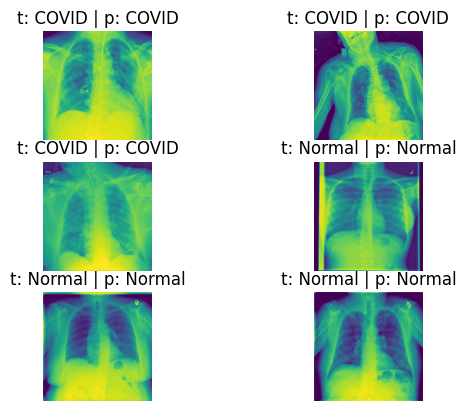

In [19]:
@torch.no_grad()
def visualize_model(model, num_images=6):
    model.eval()
    images_handled = 0
    ax = plt.figure()

    # classes =  ['Lung_Opacity', 'Viral Pneumonia', 'Normal', 'COVID']# ['Normal', 'Abnormal'] # LungsDataset.CLASSES
    classes =  ['Normal', 'COVID']# ['Normal', 'Abnormal'] # LungsDataset.CLASSES
    for i, batch in enumerate(dataloaders['val']):
        inputs, labels = batch['image'].to(device), batch['label'].to(device)

        outputs = model(inputs)
        #         preds = (outputs > 0).byte().squeeze(1)
        preds = outputs.argmax(1)

        for j in range(inputs.size()[0]):
            images_handled += 1
            ax = plt.subplot(num_images // 2, 2, images_handled)
            ax.axis('off')
            ax.set_title('t: {} | p: {}'.format(classes[labels[j].item()], classes[preds[j]]))
            imshow(inputs.cpu()[j], (5, 5), ax=ax)

            if images_handled == num_images:
                return


visualize_model(model)
plt.show()

In [20]:
torch.save(model.state_dict(), 'resnet18_mahmoud_TwoClasses_m_pretrain.pth')
validation_epoch(test_loader, model, criterion)

val:   0%|          | 0/356 [00:00<?, ?it/s]

Validation report:
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97      2970
       COVID       0.96      0.97      0.96      2712

    accuracy                           0.97      5682
   macro avg       0.97      0.97      0.97      5682
weighted avg       0.97      0.97      0.97      5682



0.10114453872948319

In [21]:
@torch.no_grad()
def predict_probs(loader, model):
    model.eval()
    probs = []
    classes = []
    for i, batch in tqdm.tqdm(enumerate(loader), total=len(loader)):
        inputs, labels = batch['image'].to(device), batch['label'].to(device)
        #print(labels)
        outputs = model(inputs)
        #         preds = outputs.sigmoid().squeeze(1)
        preds = outputs.softmax(1)
        probs.extend(preds.cpu().numpy())
        classes.extend(labels.cpu().numpy())
    return probs, classes


_, test_loader = get_dataloaders(use_sampler=False, batch_size=32, shuffle_test=False)
probs, classes = predict_probs(test_loader, model)

  0%|          | 0/178 [00:00<?, ?it/s]

(array([2970., 2712.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

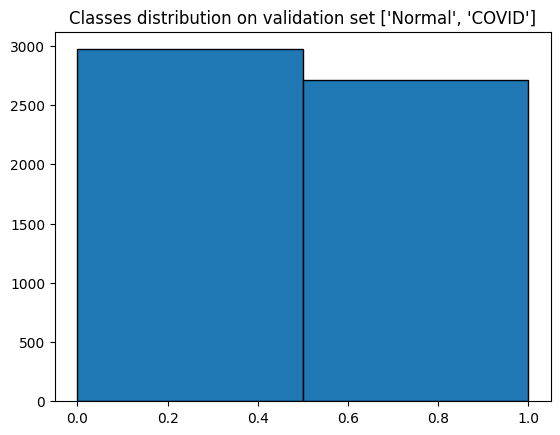

In [22]:
# plt.title('Classes distribution on validation set ' + str(['Lung_Opacity', 'Viral Pneumonia', 'Normal', 'COVID']))
plt.title('Classes distribution on validation set ' + str(['Normal', 'COVID']))
plt.hist(classes, bins=len(LungsDataset.CLASSES), edgecolor='black')

[2718 2964]
[2964 2718]


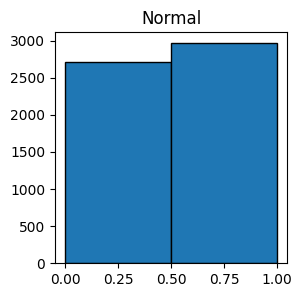

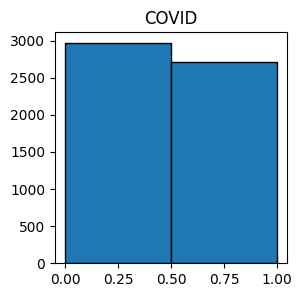

In [23]:

for explain_class in range(len(['Normal', 'COVID'])):
    pbs = [item[explain_class] for item in probs]
    hist, bins = np.histogram(pbs, range=(0, 1), bins=2)
    plt.figure(figsize=(3, 3))
    plt.hist(pbs, bins=bins, edgecolor='black')
    plt.title(['Normal', 'COVID'][explain_class])
    print(hist)

In [30]:
# all the above are related to the black-box classifire output on the test set

In [ ]:
# CLASSES = 'Normal', 'Abnormal' #'Lung_Opacity', 'Viral Pneumonia', 'Normal', 'COVID'
# for classs in CLASSES:
#     print("\n====================", classs, ['Normal', 'Abnormal'].index(classs))
    
#     explain_class = ['Normal', 'Abnormal'].index(classs)
#     pbs = [item[explain_class] for item in probs]
#     num_bins = 2
#     bin_step = 1 / num_bins
#     bins = np.arange(0, 1, bin_step)
#     bin_ids = np.digitize(pbs, bins=bins) - 1
#     for i, (x, y) in enumerate(zip(pbs, bin_ids)):
#         if x < 1e-3:
#             continue
#         print(x, y)
#         if i > 50:
#             break

In [32]:
# !pip3.9 install easydict
# !pip3.9 install lightning
# !pip3.9 install batchgenerators
# !pip3.9 install flashtorch

In [2]:
%pwd

'/gpfs/space/home/shoush/nn_project/project/counterfactual-search/src/notebooks'

In [3]:
%cd /gpfs/space/home/shoush/nn_project/project

/gpfs/space/home/shoush/nn_project/project


/gpfs/space/home/shoush/nn_project/project/NNProject/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
# module load python/3.9.12

In [5]:
# !pip install --no-cache-dir -r ./counterfactual-search/requirements.txt --extra-index-url https://download.pytorch.org/whl/cu117
# !pip install -e .
# !pre-commit install

In [1]:
from torchvision import models

In [6]:
import torchvision

In [6]:
%load_ext autoreload
%autoreload 2
%cd /gpfs/space/home/shoush/nn_project/project

import os

#!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb=128
import torch
torch.cuda.empty_cache()
# Manually set SLURM environment variables if they are not set
if "SLURM_NTASKS" not in os.environ:
    os.environ["SLURM_NTASKS"] = "2"
if "SLURM_NTASKS_PER_NODE" not in os.environ:
    os.environ["SLURM_NTASKS_PER_NODE"] = "2"

    
print("SLURM_NTASKS:", os.environ.get("SLURM_NTASKS"))
print("SLURM_NTASKS_PER_NODE:", os.environ.get("SLURM_NTASKS_PER_NODE"))

    
print("Starting Counterfactual....")
!./NNProject/bin/python ./counterfactual-search/tools/train.py -c ./counterfactual-search/configs/counterfactual/cf_inpainting_mahmoud.yaml
print("Done with CounterFactual")


# print("Starting Counterfactual....")
# !./NNProject/bin/python ./counterfactual-search/tools/train.py -c ./counterfactual-search/configs/counterfactual/cf_inpainting_mahmoud.yaml
# print("Done with CounterFactual")

SLURM_NTASKS: 2
SLURM_NTASKS_PER_NODE: 2
Starting Counterfactual....
Here....

opt: Namespace(config_path='./counterfactual-search/configs/counterfactual/cf_inpainting_mahmoud.yaml', continue_path=None)


args: Namespace(config_path='./counterfactual-search/configs/counterfactual/cf_inpainting_mahmoud.yaml', continue_path=None)

Using SNConv in generator: True
Generator in channels [1024, 1536, 768, 384, 192]
Generator out channels [1024, 512, 256, 128, 64]
Using SNConv in generator: True
Using perturbation fuse scheme: skip_add_tanh
/gpfs/space/home/shoush/nn_project/project/NNProject/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/gpfs/space/home/shoush/nn_project/project/NNProject/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecat

In [4]:
!pwd

/gpfs/space/home/shoush/nn_project/project


In [5]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%cd /gpfs/space/home/shoush/nn_project/project

import os

#!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb=128
import torch
torch.cuda.empty_cache()
# Manually set SLURM environment variables if they are not set
if "SLURM_NTASKS" not in os.environ:
    os.environ["SLURM_NTASKS"] = "2"
if "SLURM_NTASKS_PER_NODE" not in os.environ:
    os.environ["SLURM_NTASKS_PER_NODE"] = "2"

    
print("SLURM_NTASKS:", os.environ.get("SLURM_NTASKS"))
print("SLURM_NTASKS_PER_NODE:", os.environ.get("SLURM_NTASKS_PER_NODE"))

    
print("Starting eval_counterfactual....")
#!./NNProject/bin/python ./counterfactual-search/tools/eval_counterfactual.py -cp './training_logs/paper_experiments_reproduce/cf_covid/counterfactual_lungs_cgan-May-29-2024_04+52PM-0000000-mahmoud_trial/'  -cft 0.25 -pcf
!./NNProject/bin/python ./counterfactual-search/tools/eval_counterfactual.py -cp \
"/gpfs/space/home/shoush/nn_project/project/training_logs/paper_experiments_reproduce/cf_covid_clf-explain-lungs/counterfactual_lungs_cgan-May-29-2024_09+55PM-0000000-mahmoud_trial_clf-explain-lungs/" -cft 0.25 -pcf


# './training_logs/paper_experiments_reproduce/cf_covid_clf-explain-lungs/cf_covid_clf-explain-lungs/counterfactual_lungs_cgan-May-29-2024_09+55PM-0000000-mahmoud_trial_clf-explain-lungs/'  -cft 0.25 -pcf
# './training_logs/paper_experiments_reproduce/cf_covid_clf-explain-lungs/counterfactual_lungs_cgan-May-29-2024_09+55PM-0000000-mahmoud_trial_clf-explain-lungs/checkpoints/checkpoint_10.pth'

# './training_logs/paper_experiments_reproduce/synth_cf_explanations_vs_cf_inpainting/counterfactual_lungs_cgan-May-29-2024_01+51PM-0000000-tsm_synth-large_r18_bs16_arch4_fp32-fr_nearest_sc-1234_fix-prepr_df-fuse_cyclic_tv005_inpainting_v2/' -cft 0.25 -pcf

print("Done with eval_counterfactual")


# print("Starting Counterfactual....")
# !./NNProject/bin/python ./counterfactual-search/tools/train.py -c ./counterfactual-search/configs/counterfactual/cf_inpainting_mahmoud.yaml
# print("Done with CounterFactual")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/gpfs/space/home/shoush/nn_project/project
SLURM_NTASKS: 2
SLURM_NTASKS_PER_NODE: 2
Starting eval_counterfactual....
Using SNConv in generator: True
Generator in channels [1024, 1536, 768, 384, 192]
Generator out channels [1024, 512, 256, 128, 64]
Using SNConv in generator: True
Using perturbation fuse scheme: skip_add_tanh
/gpfs/space/home/shoush/nn_project/project/NNProject/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/gpfs/space/home/shoush/nn_project/project/NNProject/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(